***

<h1><center> Deep learning Model for store sales forecasting </center></h1>
<h2><center>Created by: Ginta Grinfelde</center></h2> 

***

In [ ]:
import pandas as pd
import pandas.io.sql as psql
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
! pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, Activation

In [ ]:
!pip install tensorflow_addons
from tensorflow_addons.metrics import RSquare

#### Setting up the data from the Jupyter notebook

In [ ]:
df_r = pd.read_csv('/content/drive/MyDrive/rossman.csv')
df_s = pd.read_csv('/content/drive/MyDrive/store.csv')
df = df_r.merge(df_s, on='Store', how='left')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


#### Transforming the data


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:

df['Date_i'] = df['Date']
df.set_index('Date_i', inplace=True)
df.sort_index(inplace=True)
df_train = df[df.index < '2015-05-01']
df_valid = df[df.index >= '2015-05-01']
df_full = [df_train, df_valid]

In [ ]:
sunday_sales = df[(df['DayOfWeek'] == 7) & (df['Sales'] > 0)]
store_list = sunday_sales['Store'].to_list()

for x in df_full:
    x['StateHoliday'] = x['StateHoliday'].replace(0, str(0))
    x['StateHoliday'] = x['StateHoliday'].astype(str)


    x['OpenSundays'] = x['Store'].isin(store_list).astype(int)

    x['Month'] = x['Date'].dt.month

    x['Weekend_weekday'] = x['DayOfWeek'].apply(lambda x: 'Weekday' if x<6 else 'Weekend')


In [ ]:
df_train['Christmas'] = ['2013-12-25' if d ==2013 else ('2014-12-25' if d == 2014 else '2015-12-25') for d in df_train['Date'].dt.year]
df_valid['Christmas'] = ['2013-12-25' if d ==2013 else ('2014-12-25' if d == 2014 else '2015-12-25') for d in df_valid['Date'].dt.year]
df_train['Christmas'] = pd.to_datetime(df_train['Christmas'])
df_valid['Christmas'] = pd.to_datetime(df_valid['Christmas'])

for x in df_full:
    x['Days_to_Christmas'] = x['Date'] - x['Christmas']
    x['Days_to_Christmas'] = x['Days_to_Christmas'].astype(str).str.replace('days', '').astype(int).abs()

In [ ]:

store_ranking = df.groupby('Store')['Sales'].mean().sort_values(ascending=False).rank(ascending=False).to_dict()
for x in df_full:
    x['Rank'] = [int(store_ranking[r]) for r in x['Store']]

In [ ]:

X_train = df_train.drop(columns='Sales')
y_train = df_train['Sales']

X_valid = df_valid.drop(columns='Sales')
y_valid = df_valid['Sales']

# Deep Learning

In [ ]:
# Setting up the pipeline and column transformers
drop = ['Promo2SinceWeek', 'Promo2SinceYear', 'Christmas', 'Date', 'Customers',\
        'Month','Weekend_weekday']

ohe_features = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

numerical_features = ['Store', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'DayOfWeek', \
                      'SchoolHoliday' , 'Open', 'Promo', 'CompetitionDistance',\
                   'Promo2', 'OpenSundays', 'Days_to_Christmas', 'Rank'] 

numeric_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')),
                                  ('scaler', StandardScaler())])

categoric_pipeline = Pipeline(steps=[('cat_imp', SimpleImputer(strategy='constant', fill_value='0')),
                                     ('ohe', OneHotEncoder())])

transformers  = [('drop_columns', 'drop', drop),
                ('num_pipeline', numeric_pipeline, numerical_features),
                ('cat', categoric_pipeline, ohe_features)]
                    
preprocessing = ColumnTransformer(transformers=transformers, remainder='passthrough', n_jobs=-1)


preprocessing.fit(X_train)

# Apply the transformation
X_train = pd.DataFrame(preprocessing.transform(X_train))
X_valid = pd.DataFrame(preprocessing.transform(X_valid))

#### Deep Learning model

I chose to have 3 hidden layers and again look at the MSE loss and the r2 metrics

In [ ]:
model = Sequential()
model.add(Dense(256, input_shape=(27,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))


model.compile(loss='mean_squared_error', optimizer='adam', metrics=[RSquare()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7168      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,985
Trainable params: 105,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fitting the data
history = model.fit(X_train, y_train, epochs=50)

Epoch 1/50
28583/28583 [==============================] - 91s 3ms/step - loss: 1759969.2500 - r_square: 0.8808
Epoch 2/50
28583/28583 [==============================] - 87s 3ms/step - loss: 1254508.7500 - r_square: 0.9150
Epoch 3/50
28583/28583 [==============================] - 88s 3ms/step - loss: 1161025.1250 - r_square: 0.9214
Epoch 4/50
28583/28583 [==============================] - 88s 3ms/step - loss: 1108746.2500 - r_square: 0.9249
Epoch 5/50
28583/28583 [==============================] - 86s 3ms/step - loss: 1071746.2500 - r_square: 0.9274
Epoch 6/50
28583/28583 [==============================] - 87s 3ms/step - loss: 1043226.5000 - r_square: 0.9293
Epoch 7/50
28583/28583 [==============================] - 86s 3ms/step - loss: 1022595.0000 - r_square: 0.9307
Epoch 8/50
28583/28583 [==============================] - 85s 3ms/step - loss: 1003198.1250 - r_square: 0.9321
Epoch 9/50
28583/28583 [==============================] - 84s 3ms/step - loss: 987087.8125 - r_square: 0.9331
Ep

The below graph shows that the loss decreases and then stabilizes while the r2 score does not change a lot.

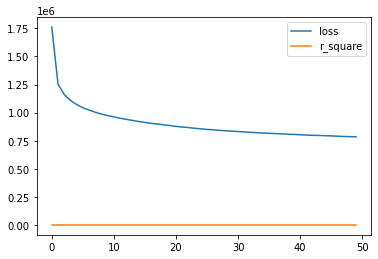

In [ ]:
pd.DataFrame(history.history).plot();

# Final Model evaluation

The score for the test set is 0.929 which is lower than my other stacked model


In [ ]:
mse, r2 = model.evaluate(X_valid, y_valid, verbose=0)
print('Test MSE: %.3f' % mse)
print('Test r2: %.3f' % r2)

Test MSE: 1084940.625
Test r2: 0.929
